# Iterative Closest Point Algorithm ( Assignment 1)

In this approach, we iteratively find the closest point on the edge. At each iteration, once we have found the closest edge points, we apply an affine transformation on the original landmark points, to get new landmmark points that are closer to the edge points. We claim to have converged when the psi stops changing.

Import required libraries

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

Helper function to plot and display images.

In [2]:
def display_image(image, title="random"):
    cv.imshow(title, image)
    cv.waitKey(0)
    cv.destroyAllWindows()

def plot_image(image, title="random"):
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

Function to find edges. We have used Canny edge detector for edge detection.

In [3]:
def find_edges(image, t1, t2):
    edges = cv.Canny(img, t1, t2)
    return edges

Function to calculate distance transform. The function takes in edges, transforms them as we did in the previous
assignment to eventually apply distance transform.

In [4]:
def distance_transform(edges):
    edges[np.where(edges == 255)] = 1.0
    edges[np.where(edges == 0)] = 255.0
    edges[np.where(edges == 1)] = 0.0
    dist = cv.distanceTransform(edges, cv.DIST_L2, 3).astype(np.uint8)
    return dist

Function to calculate gradient of the Distance Transform in 2D

In [5]:
def gradient_D(D):
    Gy, Gx = np.gradient(D)
    return Gy, Gx

Function to read the given data

In [6]:
def read_text_file(filepath):
    with open(filepath) as f:
        data = [tuple(map(int, i[1:-2].split(','))) for i in f]
    return np.array(data)

We have used the following steps to achieve ICP goal.

    step 1 : Find edges of the hand image using Canny
    step 2 : Pre-compute the distance transform of the image
    step 3 : For each point w find the closest point in the edges.(Correspondence)
             a. w = Point on the shape model. (trasnformed)
             b. E = Point in the edge list.
             c. D : Distance transform at point (w)
             d. G = Find the gradient of the distance transform.
             e. x = (w - (D/Magnitude(G))*(Gx*Gy))
    step 4 : Find an affine transformation using closed form solution.

In [7]:
def iterartive_closest_points(img):
    '''
         w = Point on the shape model. (trasnformed)
         E = Point in the edge list.
         D : Distance transform at point (w)
         G = Find the gradient of the distance transform.
         x = (w - (D/Magnitude(G))*(Gx*Gy))
    '''
    E = find_edges(img, 40, 80)
    D = distance_transform(E).astype(np.float32)
    Gy, Gx = gradient_D(D)
    G = np.array([Gy.T, Gx.T]).T
    G_magnitude = np.hypot(Gx, Gy)
    '''
    Read the hand landmark points. 
    '''
    hand_landmarks = read_text_file('data/hand_landmarks.txt')
    hand_landmarks = np.array([hand_landmarks.T[1], hand_landmarks.T[0]]).T
    hand_landmarks_org = np.copy(hand_landmarks)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    
    params = np.zeros((6,))
    counter_iter = 0
    transformed_points = np.zeros_like(hand_landmarks)
    while (True):
        '''
        Find correspondence by putting value of w' in above values.
        '''
        D_sub = D[hand_landmarks.T[0], hand_landmarks.T[1]]
        G_sub = G[hand_landmarks.T[0], hand_landmarks.T[1]]
        G_magnitude_sub = G_magnitude[hand_landmarks.T[0], hand_landmarks.T[1]]
        second_numerator = D_sub.reshape(-1, 1) * G_sub
        second_denomenator = G_magnitude_sub.reshape(-1, 1)
        second_term = np.divide(second_numerator, second_denomenator, where=second_denomenator != 0)
        second_term = second_term
        '''
        Calculate final correspondence and store it in x
        '''
        x = (hand_landmarks - second_term).astype(int)
        '''
        Define the A.x=b components for performing the psuedo inverse.
        A = [...[xi yi 0 1 0]
            [0 0 xi yi 0 1]...]
        x = [m1,m2,m3,m4,t1,t2]
        b = [.....xi,yi,....]
        '''
        A = []
        for point in hand_landmarks:
            A = A + [[point[1], point[0], 0, 0, 1, 0]]
            A = A + [[0, 0, point[1], point[0], 0, 1]]
        A = np.array(A)
        b = np.array([x.T[1],x.T[0]]).T.flatten()
        '''
        Apply psuedo inverse formula to get psi.
        '''
        params_new = np.dot(np.dot(np.linalg.inv(np.dot(A.T, A)), A.T), b)
        '''
        Check for convergence.
        '''
        if np.array_equal(params_new,params):
            break
        params = params_new
        '''
        Transform the points to update landmark points.
        '''
        transformed_points = np.dot(A, params).reshape(65, 2)
        transformed_points = np.array([transformed_points.T[1], transformed_points.T[0]]).T.astype(int)
        hand_landmarks = np.round(transformed_points).astype(int)
        counter_iter += 1
    '''
    For plotting final points.
    '''
    plt.cla()
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.scatter(transformed_points[:, 1], transformed_points[:, 0], c='#67eb34', s=5)
    plt.show()
#     plt.pause(5)
    plt.close()
    return params_new

Apply the function on the given image.

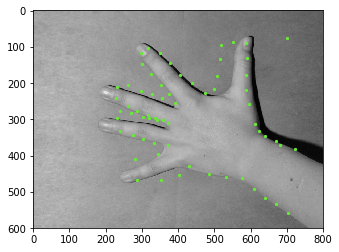

In [8]:
img = cv.imread('data/hand.jpg', 0)
params_new = iterartive_closest_points(img)

The final affine transformation matrix.

In [9]:
print(params_new)

[ 9.99371043e-01 -1.15444070e-03 -1.73811987e-04  9.98974020e-01
  1.27536574e+00  1.13667829e+00]
